## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'batch1approx1e5-agriVision-wavelet-blue ' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'd:\\Research\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\wavelet\\batch1approx1e5\\blue'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{np.int64(2): 9000,
 np.int64(3): 36000,
 np.int64(4): 144000,
 np.int64(5): 576000,
 np.int64(6): 2304000,
 np.int64(7): 9216000,
 np.int64(8): 36864000,
 np.int64(9): 147456000,
 np.int64(10): 589824000}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [01:00<00:00, 1650.93it/s]


Layer 3


100%|██████████| 100000/100000 [01:02<00:00, 1595.80it/s]


Layer 4


100%|██████████| 100000/100000 [00:57<00:00, 1732.76it/s]


Layer 5


100%|██████████| 100000/100000 [00:59<00:00, 1687.68it/s]


Layer 6


100%|██████████| 100000/100000 [00:58<00:00, 1699.75it/s]


Layer 7


100%|██████████| 100000/100000 [00:58<00:00, 1723.52it/s]


Layer 8


100%|██████████| 100000/100000 [00:58<00:00, 1721.35it/s]


Layer 9


100%|██████████| 100000/100000 [00:58<00:00, 1715.88it/s]


Layer 10


100%|██████████| 100000/100000 [00:58<00:00, 1702.37it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0


## Initial Grid Search and Hypothesis Test Plots

####
Layer  2


100%|██████████| 55966/55966 [00:27<00:00, 2062.04it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 9000, Without approximation : 9000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


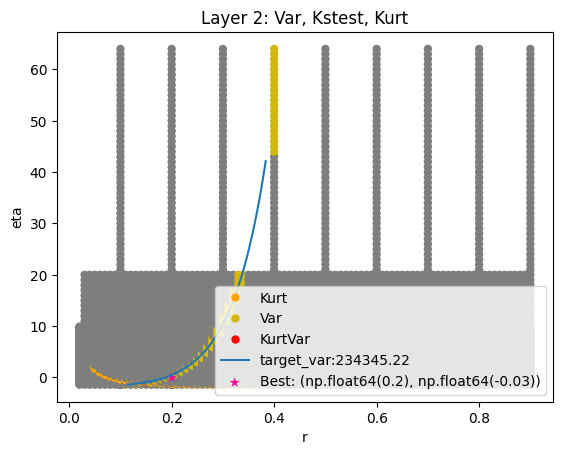

####
Layer  3


100%|██████████| 55966/55966 [01:24<00:00, 664.67it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 36000, Without approximation : 36000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


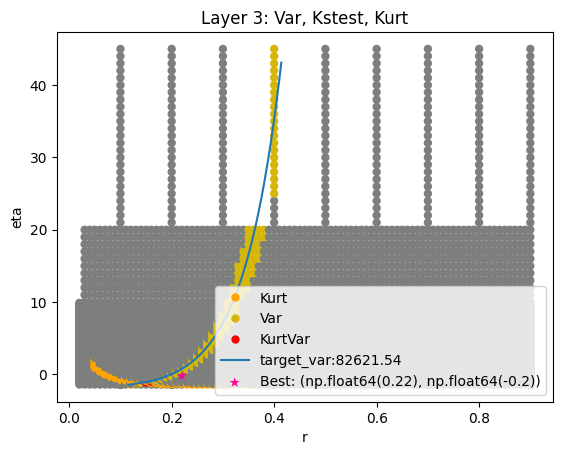

####
Layer  4


100%|██████████| 55966/55966 [04:20<00:00, 214.60it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 144000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


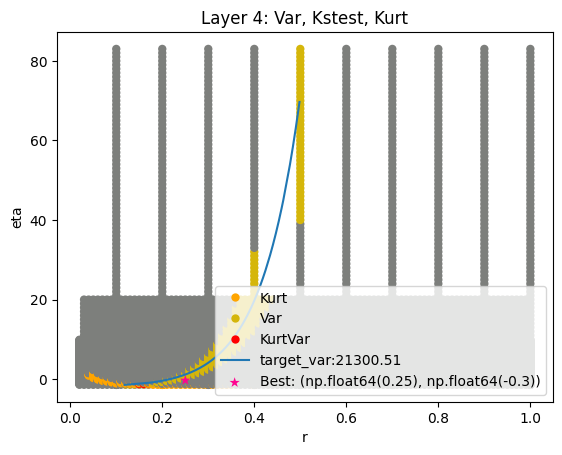

####
Layer  5


100%|██████████| 55966/55966 [04:18<00:00, 216.56it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 576000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


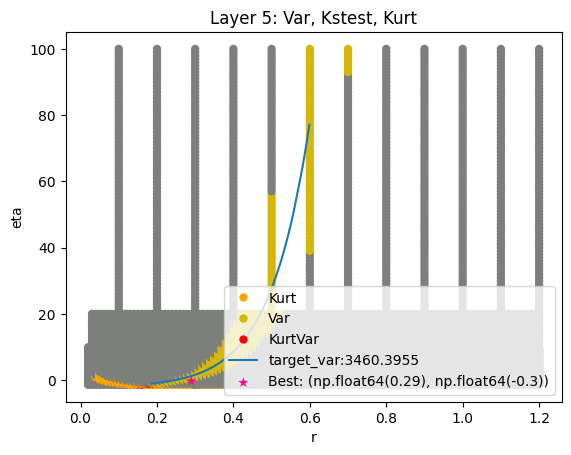

####
Layer  6


100%|██████████| 55966/55966 [04:19<00:00, 215.72it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 2304000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


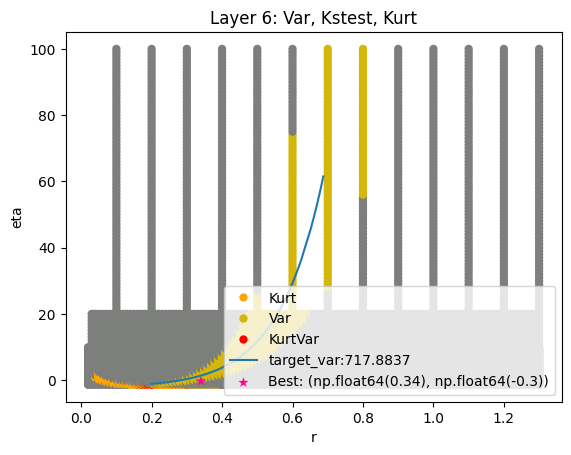

####
Layer  7


100%|██████████| 55966/55966 [04:18<00:00, 216.11it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 9216000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


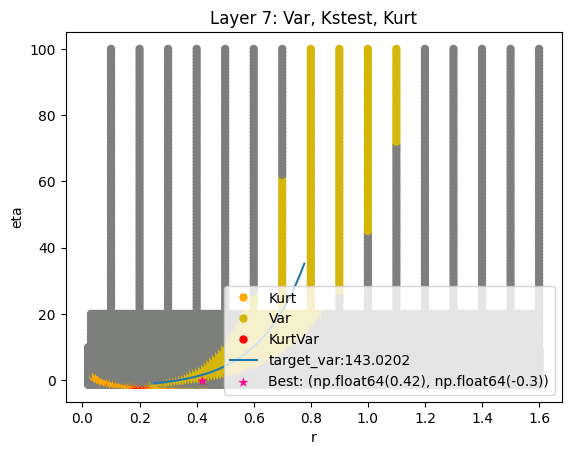

####
Layer  8


100%|██████████| 55966/55966 [04:16<00:00, 217.90it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 36864000.0


d:\Research\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


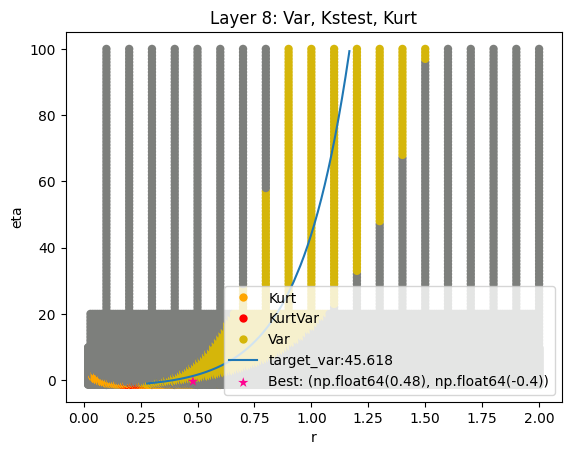

####
Layer  9


100%|██████████| 55966/55966 [04:11<00:00, 222.70it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 147456000.0


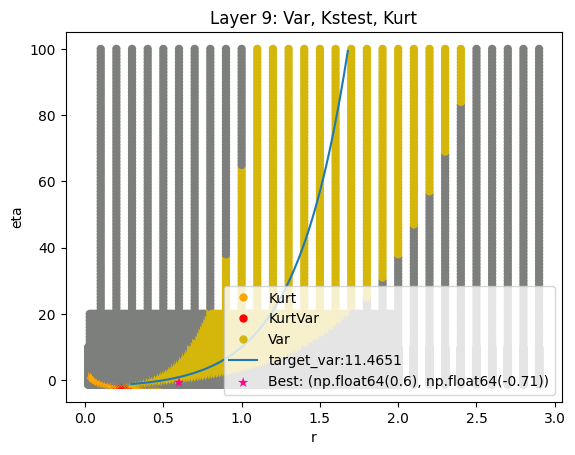

####
Layer  10


100%|██████████| 55966/55966 [04:12<00:00, 222.01it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 589824000.0


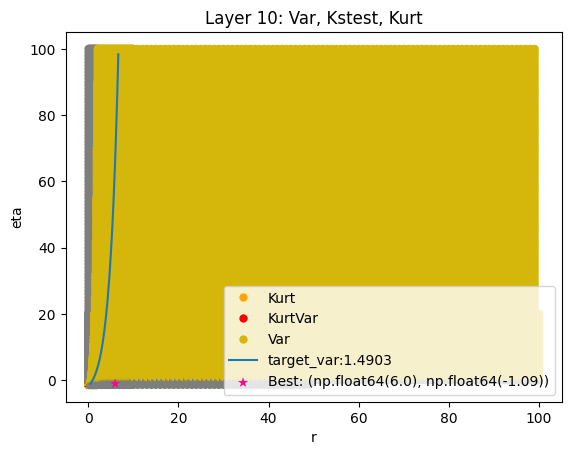

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0,0.20,-0.03,0.017002,0.014297
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0,0.22,-0.20,0.010780,0.007153
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0,0.25,-0.30,0.014160,0.003578
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0,0.29,-0.30,0.010184,0.001789
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0,0.34,-0.30,0.008785,0.000895
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0,0.42,-0.30,0.006140,0.000447
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0,0.48,-0.40,0.006340,0.000224
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0,0.60,-0.71,0.007022,0.000112
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0,6.00,-1.09,0.026510,0.000056


In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 2442.95it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 685.64it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 223.57it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 224.02it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 223.32it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 225.49it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 225.56it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 225.77it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 220.51it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0,0.20,-0.03,0.017002,0.014297,0.023825,0.20
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0,0.22,-0.20,0.010780,0.007153,0.013361,0.23
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0,0.25,-0.30,0.014160,0.003578,0.018179,0.27
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0,0.29,-0.30,0.010184,0.001789,0.016542,0.32
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0,0.34,-0.30,0.008785,0.000895,0.012230,0.38
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0,0.42,-0.30,0.006140,0.000447,0.011524,0.47
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0,0.48,-0.40,0.006340,0.000224,0.015825,0.58
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0,0.60,-0.71,0.007022,0.000112,0.026164,1.08
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0,6.00,-1.09,0.026510,0.000056,0.149006,6.20


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(np.float64(0.12), np.float64(-0.033)), 50 of 441
(np.float64(0.14), np.float64(-0.025)), 100 of 441
(np.float64(0.17), np.float64(-0.038)), 150 of 441
(np.float64(0.19), np.float64(-0.03)), 200 of 441
(np.float64(0.21), np.float64(-0.022)), 250 of 441
(np.float64(0.24), np.float64(-0.035)), 300 of 441
(np.float64(0.26), np.float64(-0.027)), 350 of 441
(np.float64(0.29), np.float64(-0.04)), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 2519.40it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 2 best parameters: ((np.float64(0.2), np.float64(-0.028)), np.float64(0.01695475160335469))


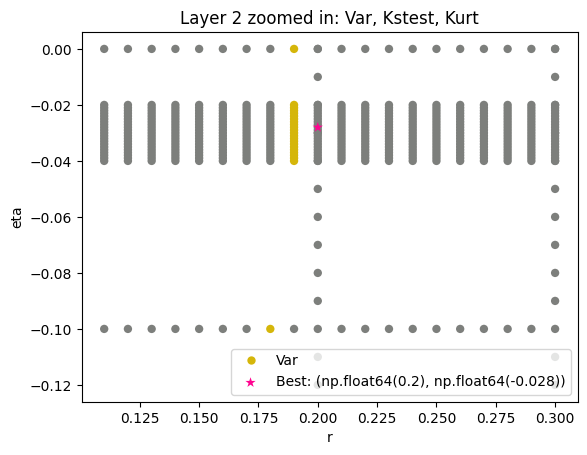

Layer 3
(np.float64(0.212), np.float64(-0.23)), 50 of 441
(np.float64(0.214), np.float64(-0.15)), 100 of 441
(np.float64(0.217), np.float64(-0.28)), 150 of 441
(np.float64(0.219), np.float64(-0.2)), 200 of 441
(np.float64(0.221), np.float64(-0.12)), 250 of 441
(np.float64(0.224), np.float64(-0.25)), 300 of 441
(np.float64(0.226), np.float64(-0.17)), 350 of 441
(np.float64(0.229), np.float64(-0.3)), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 714.59it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 3 best parameters: ((np.float64(0.219), np.float64(-0.2)), np.float64(0.008965787067282127))


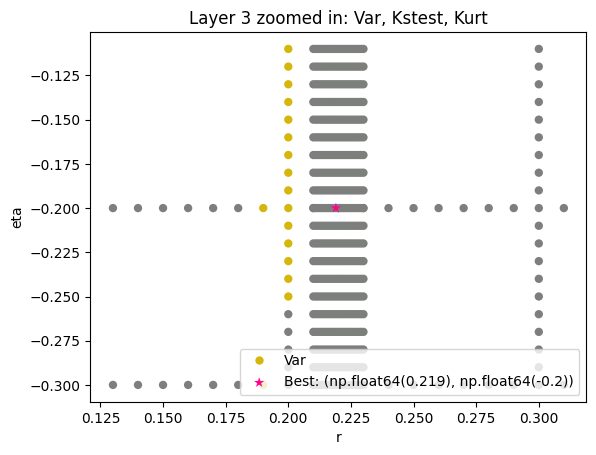

Layer 4
(np.float64(0.242), np.float64(-0.33)), 50 of 441
(np.float64(0.244), np.float64(-0.25)), 100 of 441
(np.float64(0.247), np.float64(-0.38)), 150 of 441
(np.float64(0.249), np.float64(-0.3)), 200 of 441
(np.float64(0.251), np.float64(-0.22)), 250 of 441
(np.float64(0.254), np.float64(-0.35)), 300 of 441
(np.float64(0.256), np.float64(-0.27)), 350 of 441
(np.float64(0.259), np.float64(-0.4)), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 221.00it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((np.float64(0.242), np.float64(-0.35)), np.float64(0.00939913803534198))


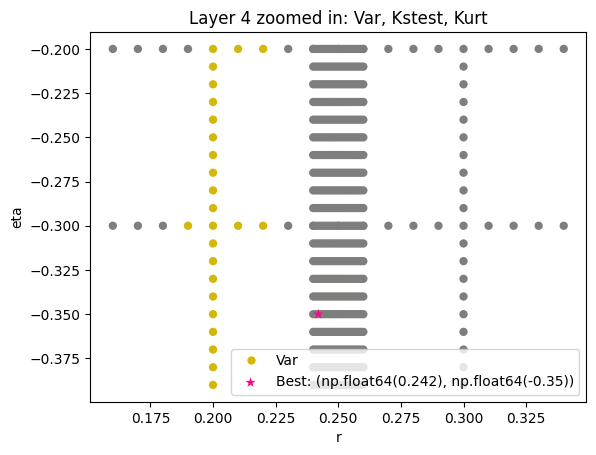

Layer 5
(np.float64(0.282), np.float64(-0.33)), 50 of 441
(np.float64(0.284), np.float64(-0.25)), 100 of 441
(np.float64(0.287), np.float64(-0.38)), 150 of 441
(np.float64(0.289), np.float64(-0.3)), 200 of 441
(np.float64(0.291), np.float64(-0.22)), 250 of 441
(np.float64(0.294), np.float64(-0.35)), 300 of 441
(np.float64(0.296), np.float64(-0.27)), 350 of 441
(np.float64(0.299), np.float64(-0.4)), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 222.36it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 5 best parameters: ((np.float64(0.281), np.float64(-0.38)), np.float64(0.008467460487737943))


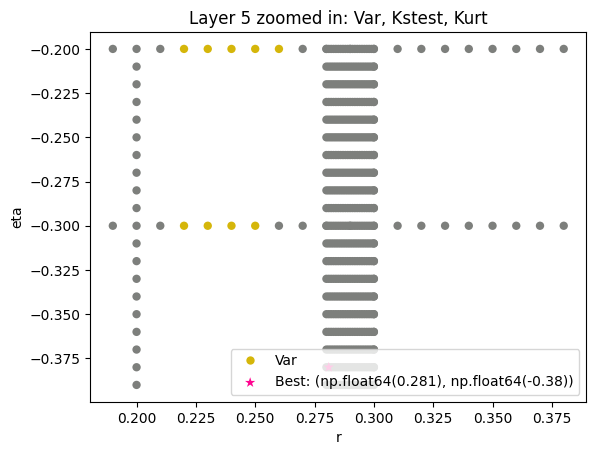

Layer 6
(np.float64(0.332), np.float64(-0.33)), 50 of 441
(np.float64(0.334), np.float64(-0.25)), 100 of 441
(np.float64(0.337), np.float64(-0.38)), 150 of 441
(np.float64(0.339), np.float64(-0.3)), 200 of 441
(np.float64(0.341), np.float64(-0.22)), 250 of 441
(np.float64(0.344), np.float64(-0.35)), 300 of 441
(np.float64(0.346), np.float64(-0.27)), 350 of 441
(np.float64(0.349), np.float64(-0.4)), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 222.89it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 6 best parameters: ((np.float64(0.337), np.float64(-0.34)), np.float64(0.006354863123258947))


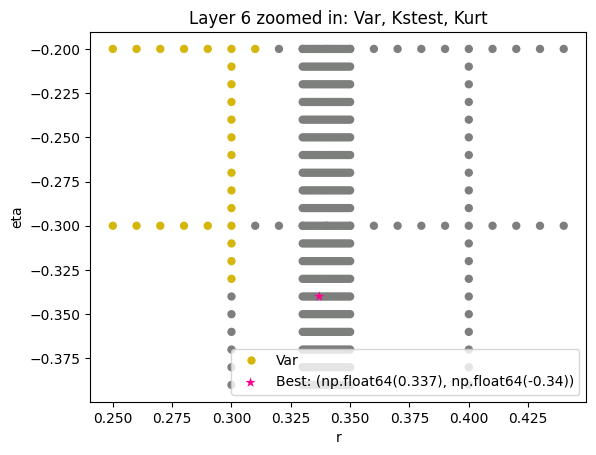

Layer 7
(np.float64(0.412), np.float64(-0.33)), 50 of 441
(np.float64(0.414), np.float64(-0.25)), 100 of 441
(np.float64(0.417), np.float64(-0.38)), 150 of 441
(np.float64(0.419), np.float64(-0.3)), 200 of 441
(np.float64(0.421), np.float64(-0.22)), 250 of 441
(np.float64(0.424), np.float64(-0.35)), 300 of 441
(np.float64(0.426), np.float64(-0.27)), 350 of 441
(np.float64(0.429), np.float64(-0.4)), 400 of 441


100%|██████████| 441/441 [00:02<00:00, 215.36it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 7 best parameters: ((np.float64(0.41), np.float64(-0.33)), np.float64(0.004868320127138559))


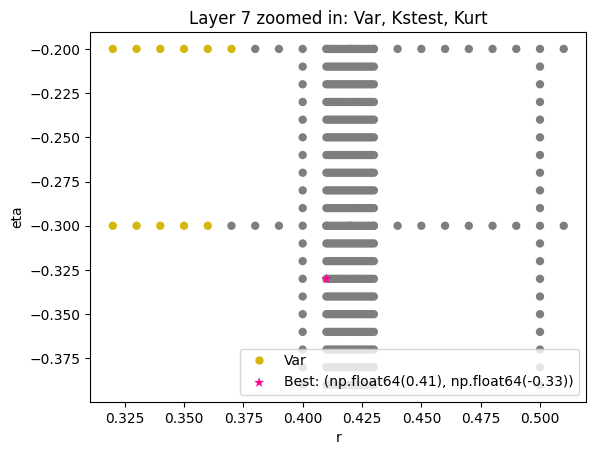

Layer 8
(np.float64(0.472), np.float64(-0.41)), 50 of 420
(np.float64(0.474), np.float64(-0.31)), 100 of 420
(np.float64(0.477), np.float64(-0.41)), 150 of 420
(np.float64(0.479), np.float64(-0.31)), 200 of 420
(np.float64(0.482), np.float64(-0.41)), 250 of 420
(np.float64(0.484), np.float64(-0.31)), 300 of 420
(np.float64(0.487), np.float64(-0.41)), 350 of 420
(np.float64(0.489), np.float64(-0.31)), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 214.37it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 8 best parameters: ((np.float64(0.471), np.float64(-0.44)), np.float64(0.0050330500097569755))


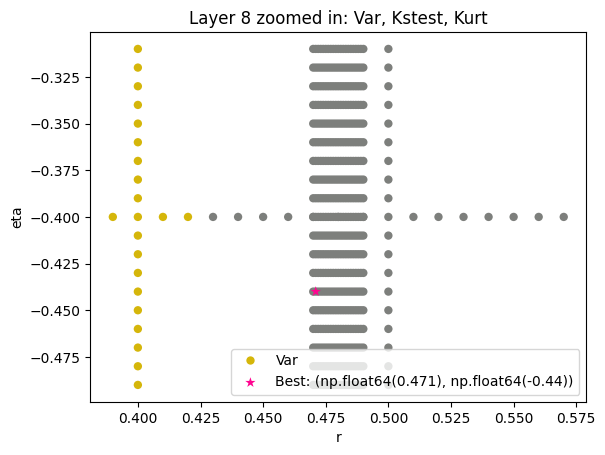

Layer 9
(np.float64(0.52), np.float64(-0.713)), 50 of 420
(np.float64(0.54), np.float64(-0.705)), 100 of 420
(np.float64(0.57), np.float64(-0.718)), 150 of 420
(np.float64(0.59), np.float64(-0.71)), 200 of 420
(np.float64(0.61), np.float64(-0.702)), 250 of 420
(np.float64(0.64), np.float64(-0.715)), 300 of 420
(np.float64(0.66), np.float64(-0.707)), 350 of 420
(np.float64(0.69), np.float64(-0.72)), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 215.02it/s]
d:\Research\hierarchical-bayesian-model-validation\utilities\plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 420 CDFs
Iter 1 layer 9 best parameters: ((np.float64(0.6), np.float64(-0.705)), np.float64(0.00638152021829241))


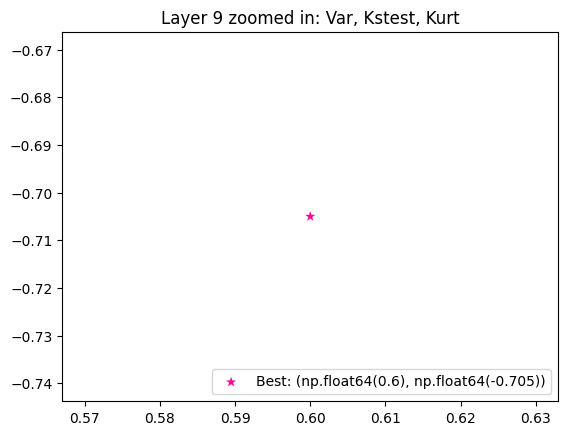

Layer 10
(np.float64(5.2), np.float64(-1.093)), 50 of 420
(np.float64(5.4), np.float64(-1.085)), 100 of 420
(np.float64(5.7), np.float64(-1.098)), 150 of 420
(np.float64(5.9), np.float64(-1.09)), 200 of 420
(np.float64(6.1), np.float64(-1.082)), 250 of 420
(np.float64(6.4), np.float64(-1.095)), 300 of 420
(np.float64(6.6), np.float64(-1.087)), 350 of 420
(np.float64(6.9), np.float64(-1.1)), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 217.57it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 10 best parameters: ((np.float64(6.6), np.float64(-1.091)), np.float64(0.026509999999956957))


d:\Research\hierarchical-bayesian-model-validation\utilities\plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


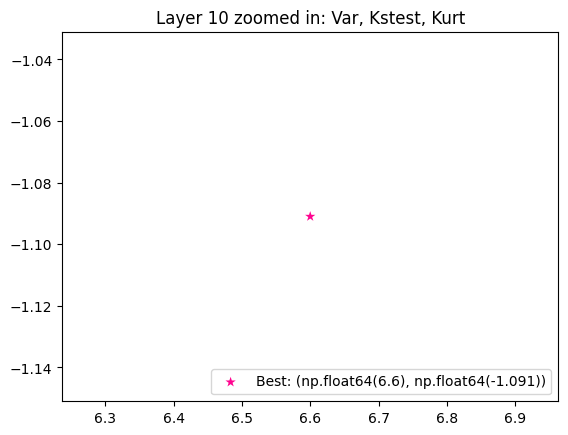

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0,0.20,-0.03,0.017002,0.014297,0.023825,0.20,0.200,-0.028,0.016955,0.200,-0.028,0.016955,6750
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0,0.22,-0.20,0.010780,0.007153,0.013361,0.23,0.219,-0.200,0.008966,0.219,-0.200,0.008966,22780
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0,0.25,-0.30,0.014160,0.003578,0.018179,0.27,0.242,-0.350,0.009399,0.242,-0.350,0.009399,20250
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0,0.29,-0.30,0.010184,0.001789,0.016542,0.32,0.281,-0.380,0.008467,0.281,-0.380,0.008467,27000
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0,0.34,-0.30,0.008785,0.000895,0.012230,0.38,0.337,-0.340,0.006355,0.337,-0.340,0.006355,45562
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0,0.42,-0.30,0.006140,0.000447,0.011524,0.47,0.410,-0.330,0.004868,0.410,-0.330,0.004868,81000
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0,0.48,-0.40,0.006340,0.000224,0.015825,0.58,0.471,-0.440,0.005033,0.471,-0.440,0.005033,72000
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0,0.60,-0.71,0.007022,0.000112,0.026164,1.08,0.600,-0.705,0.006382,0.600,-0.705,0.006382,45562
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0,6.00,-1.09,0.026510,0.000056,0.149006,6.20,6.600,-1.091,0.026510,6.600,-1.091,0.026510,2530


In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

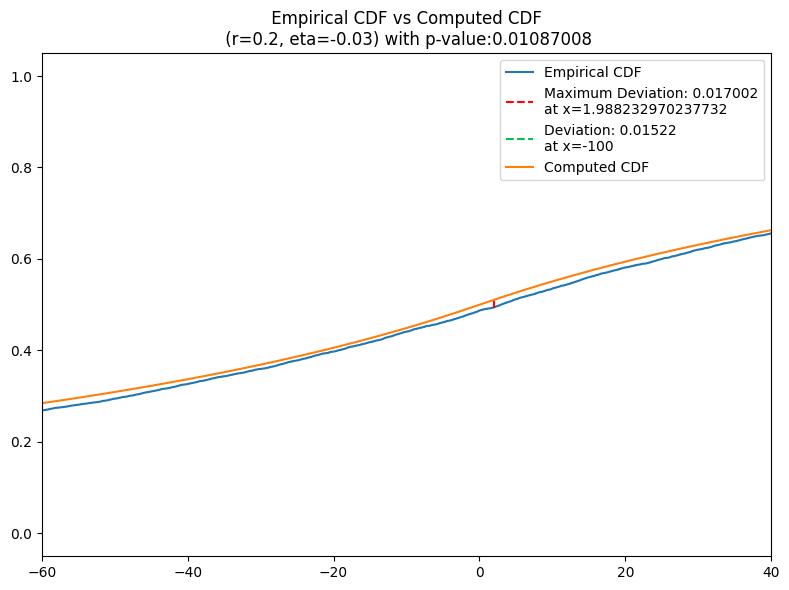

In [12]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

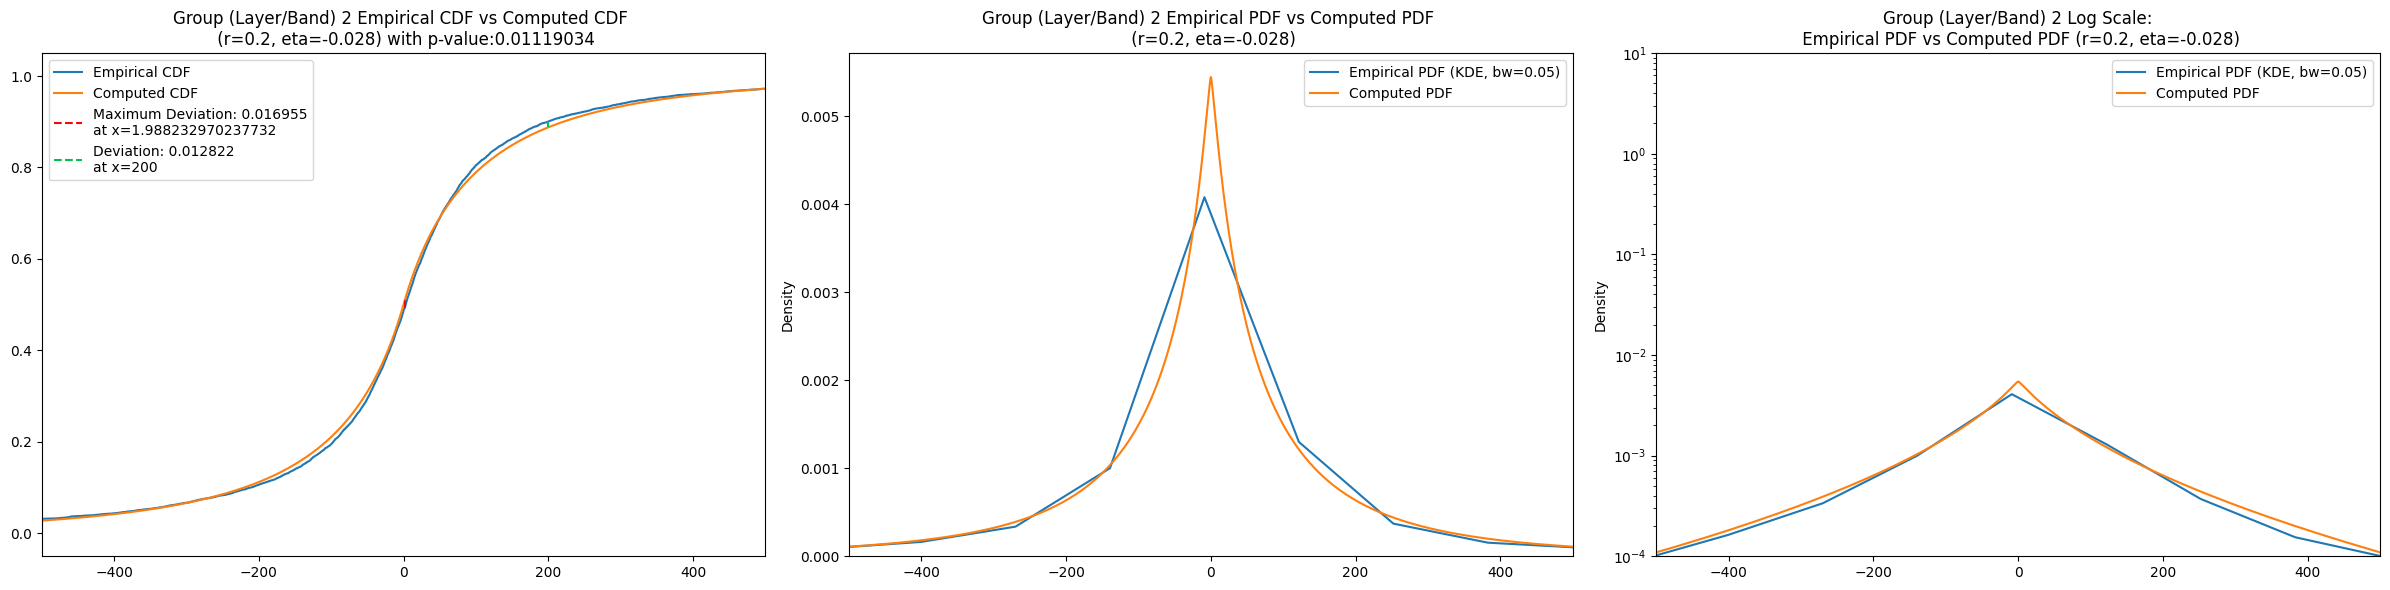

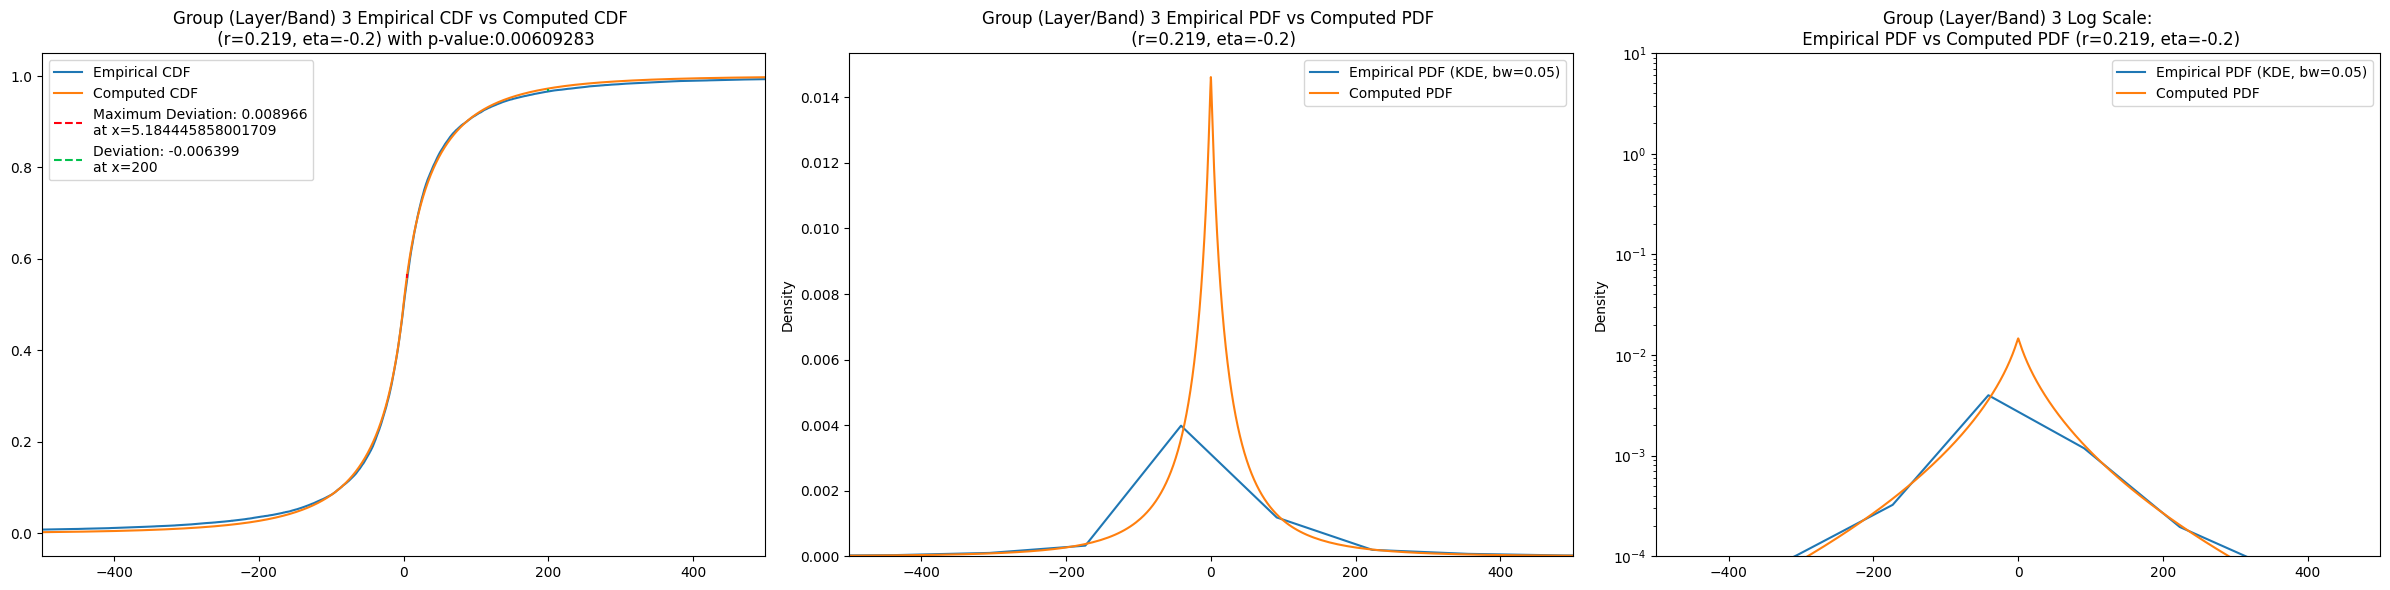

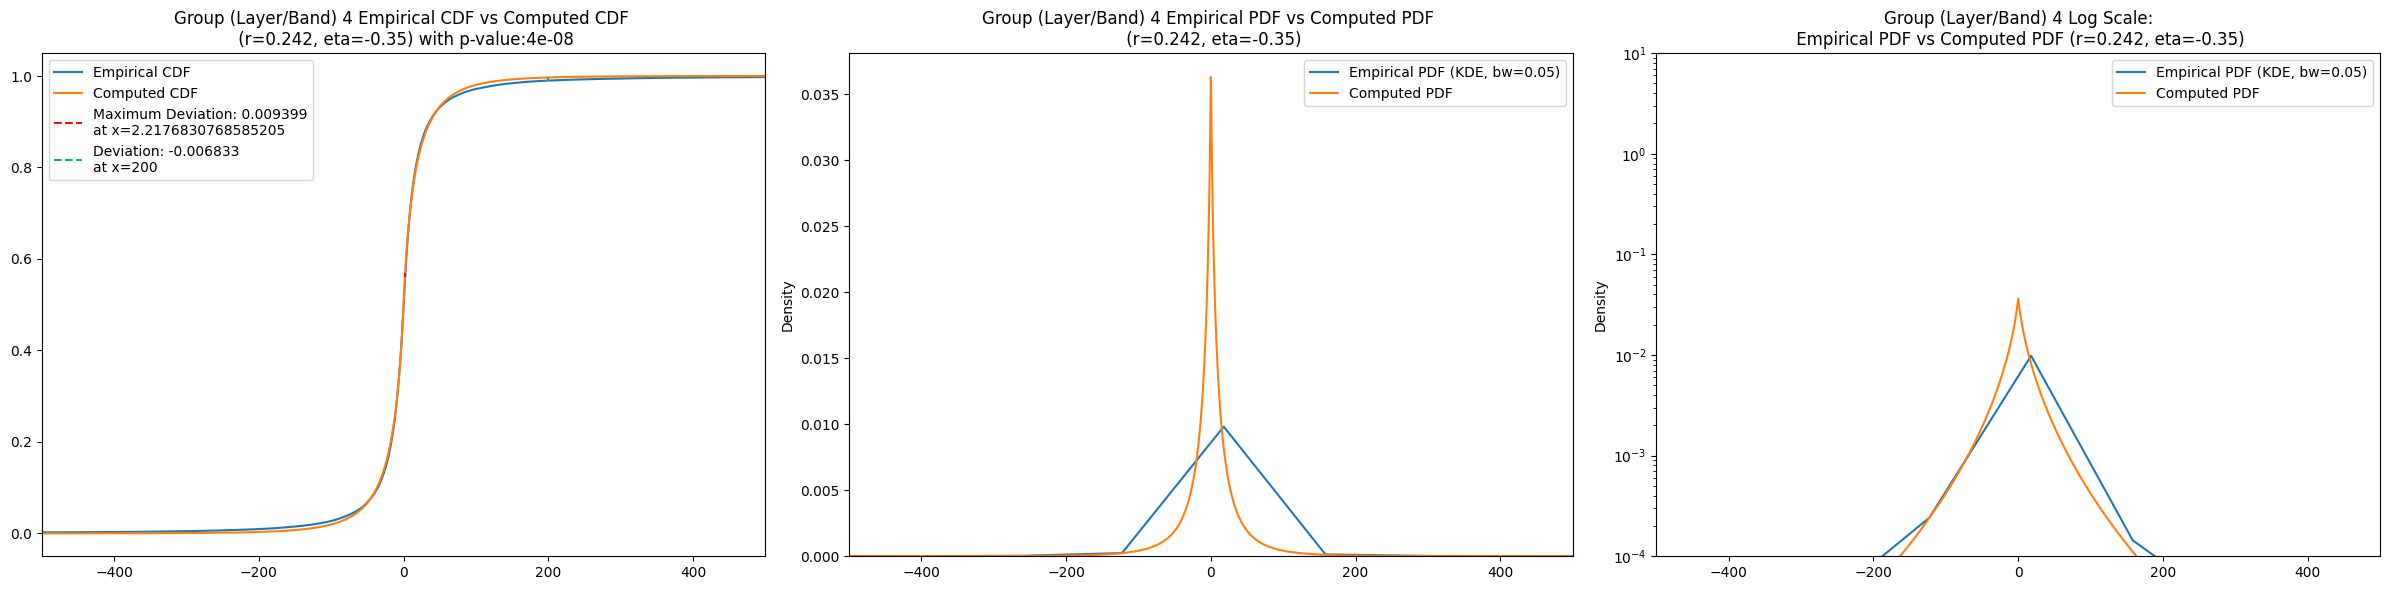

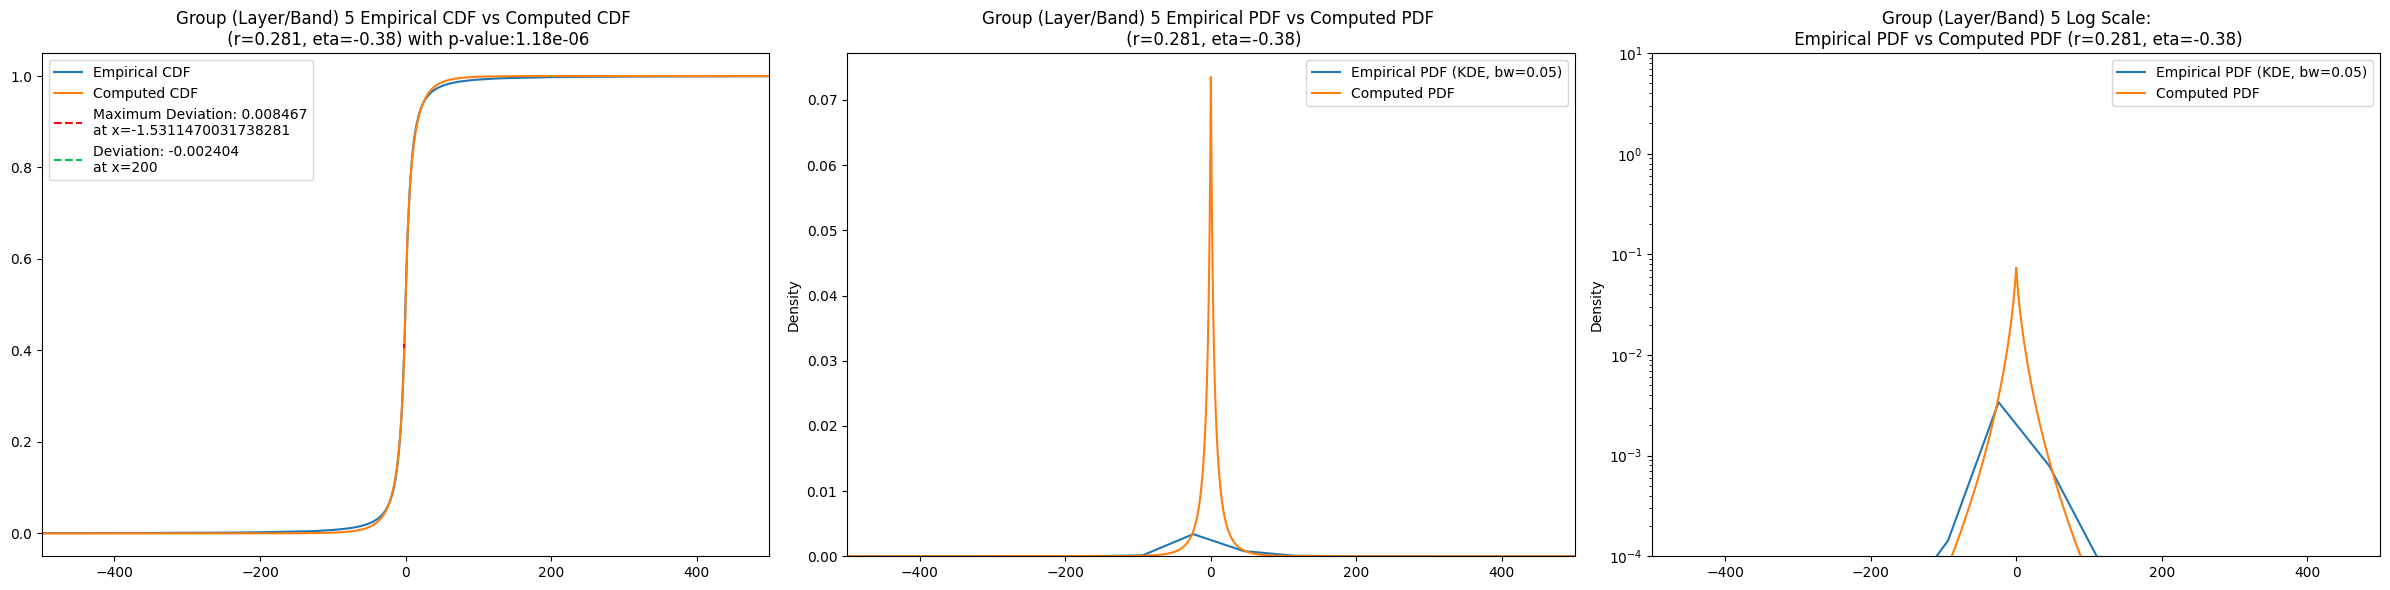

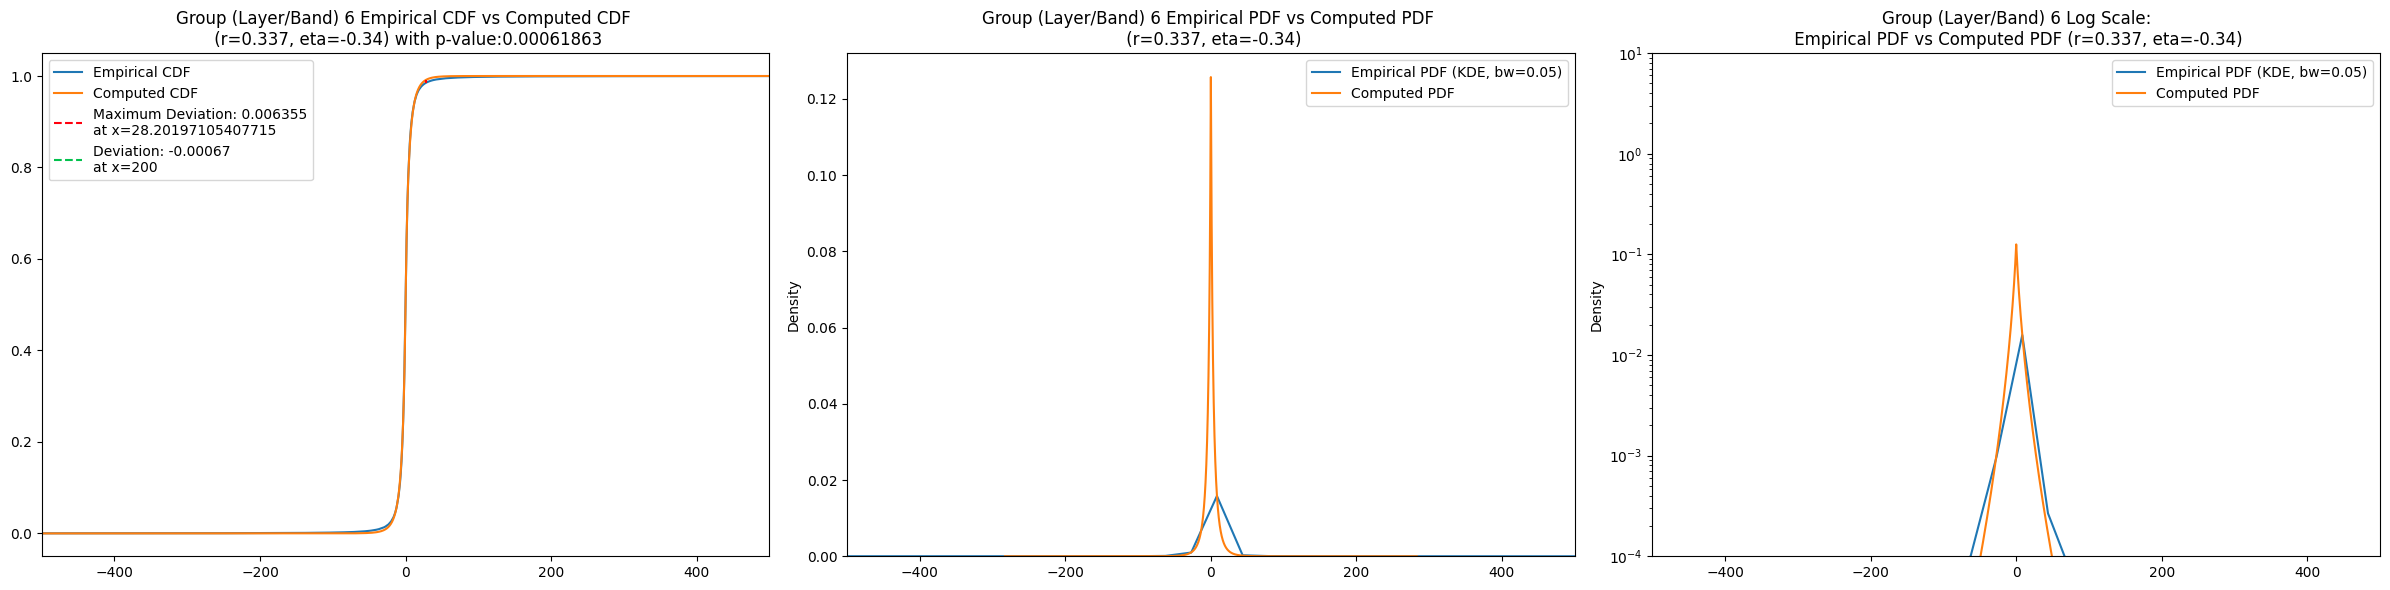

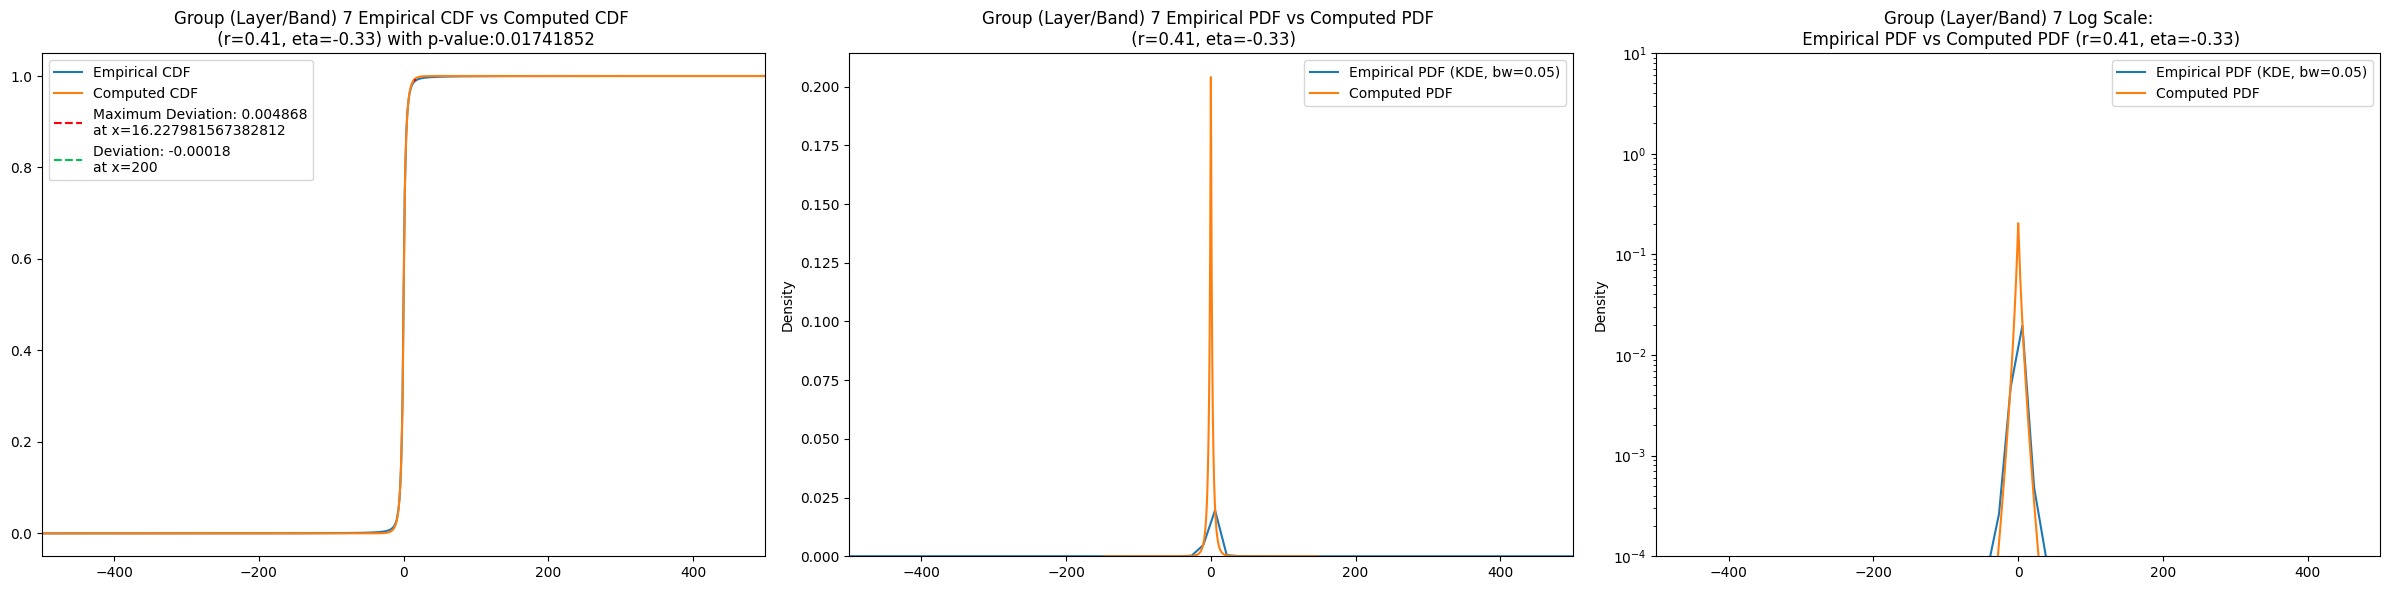

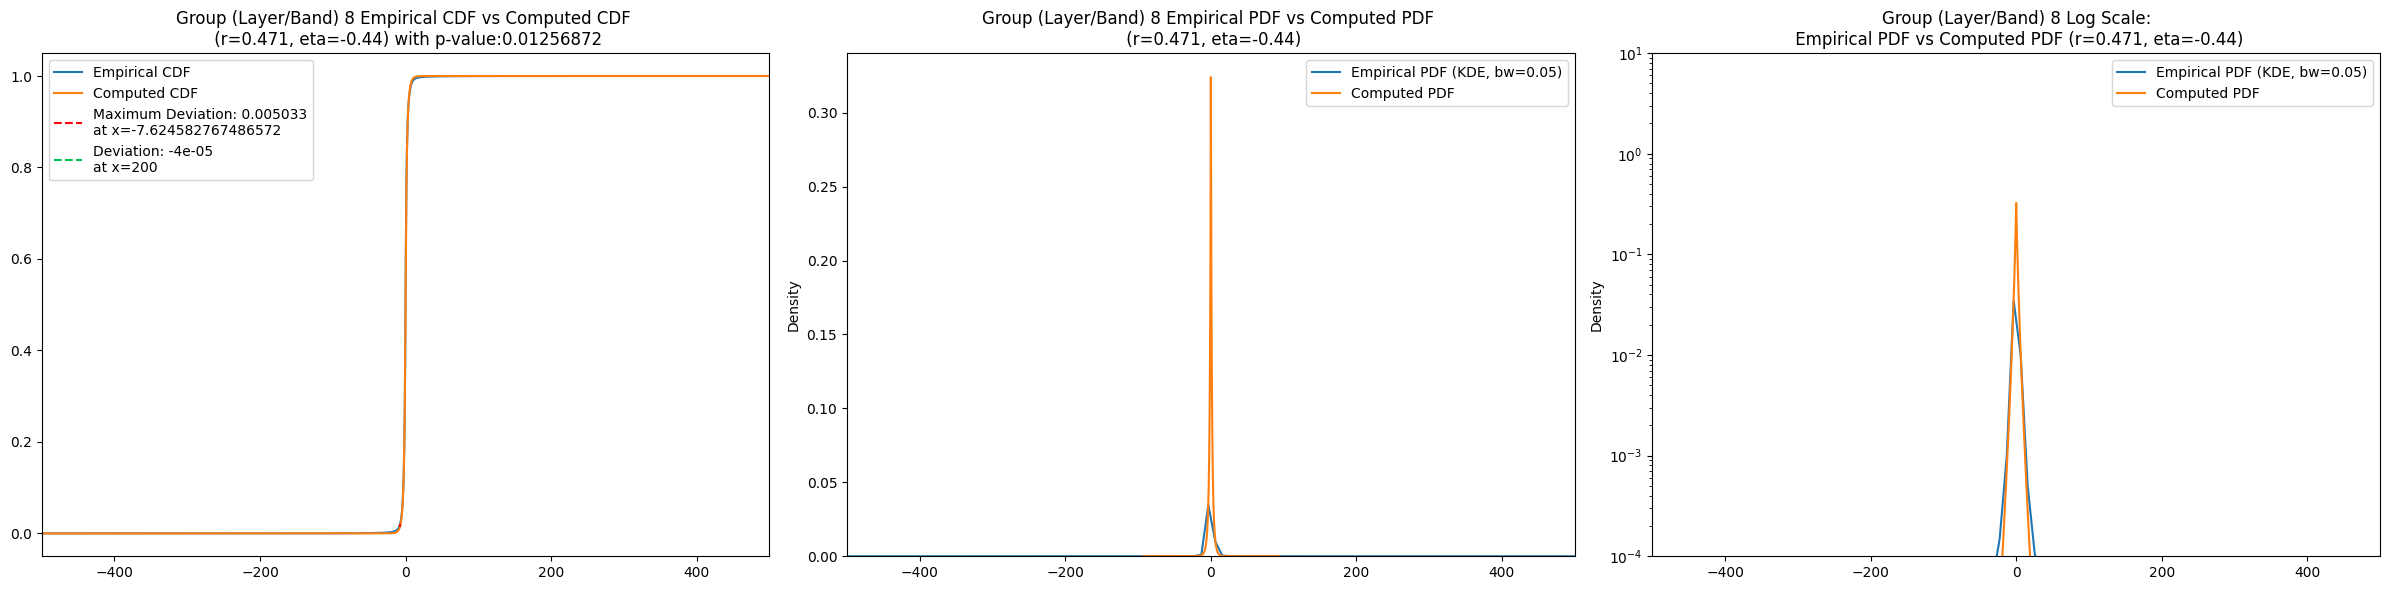

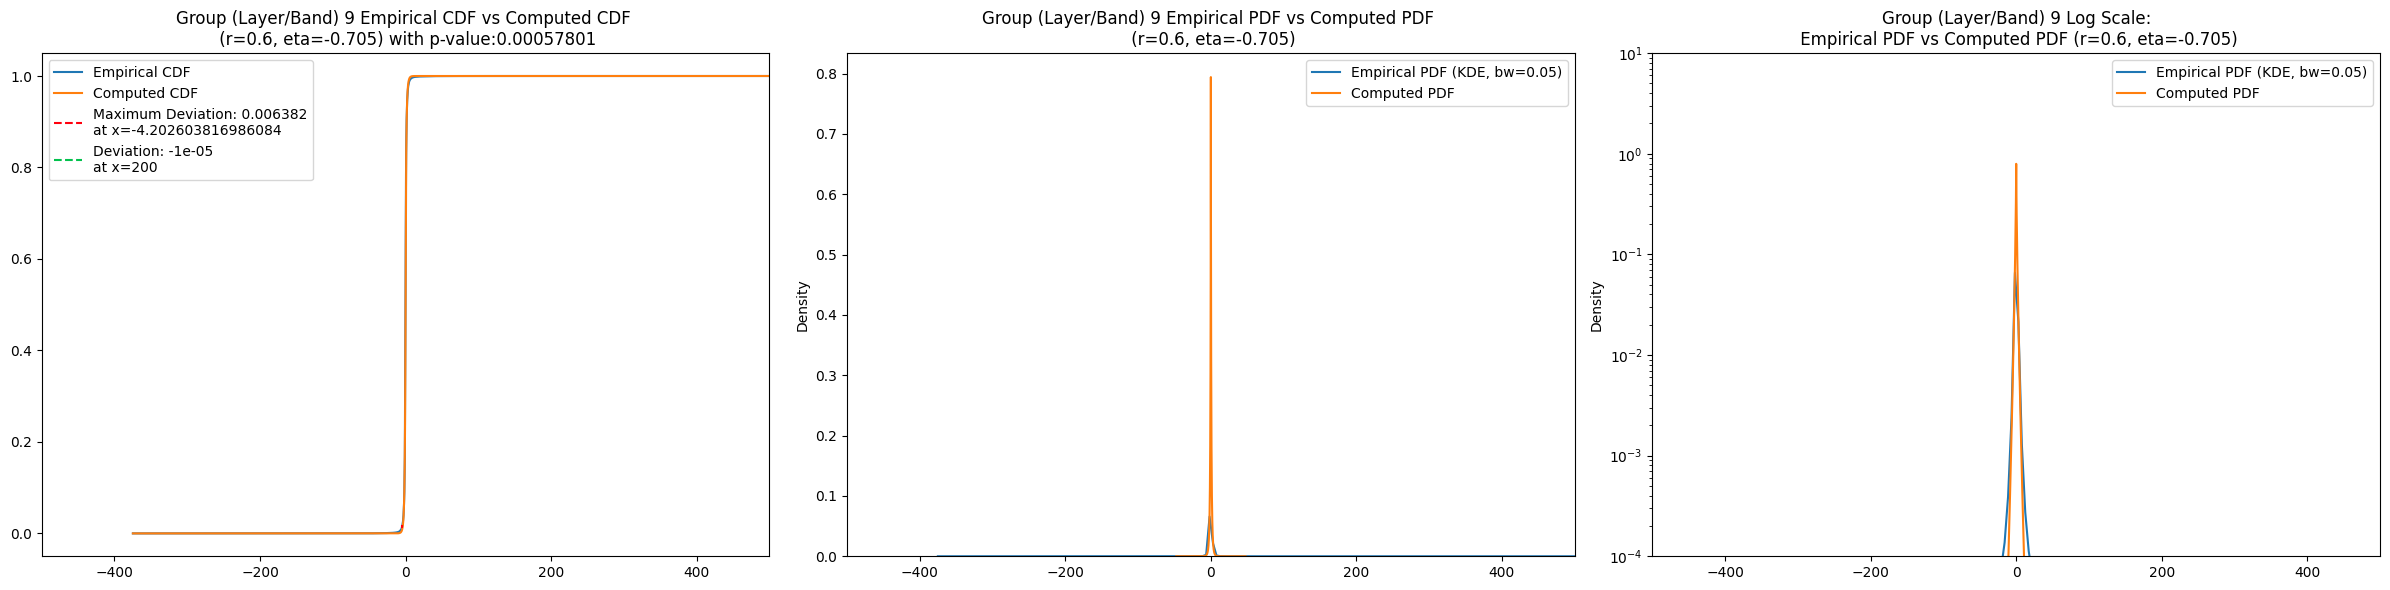

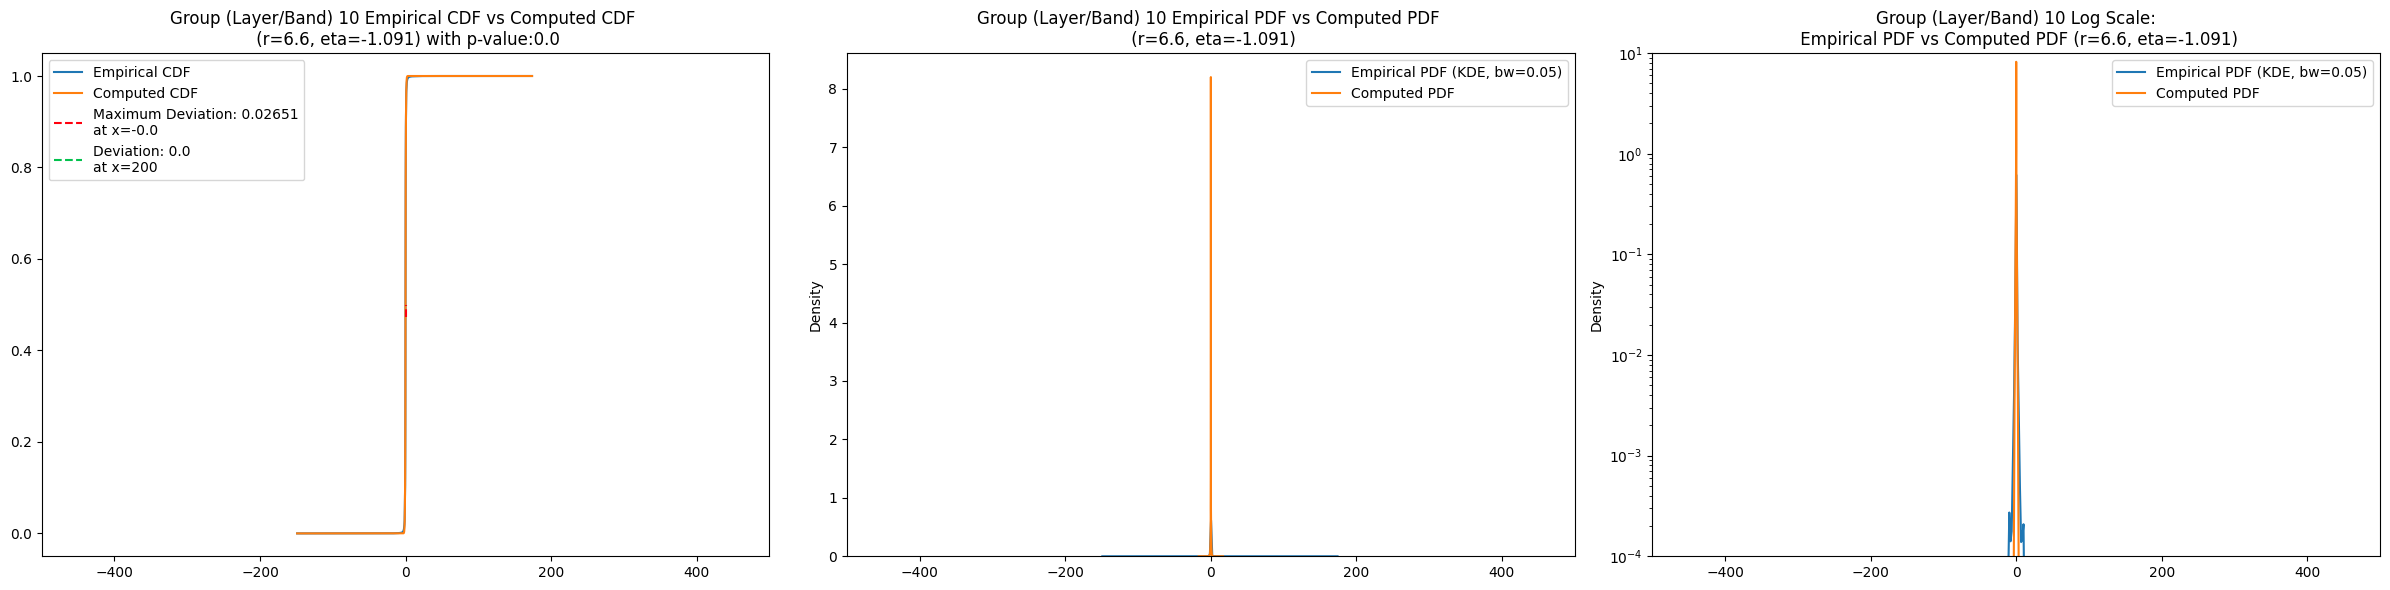

In [13]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [14]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [15]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0,0.20,-0.03,0.017002,...,131.058000,0.058041,8.526880e-27,115.256000,0.030717,8.218320e-08,91.250200,0.028504,8.714970e-07,1.119034e-02
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0,0.22,-0.20,0.010780,...,54.159900,0.055944,2.263590e-98,48.044300,0.029735,4.371200e-28,37.704000,0.026939,3.961400e-23,6.092833e-03
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0,0.25,-0.30,0.014160,...,22.900700,0.054513,0.000000e+00,20.426200,0.029243,2.040080e-107,15.952200,0.024869,8.424530e-78,1.771530e-11
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0,0.29,-0.30,0.010184,...,10.621500,0.048938,0.000000e+00,9.484290,0.023952,1.716250e-287,7.406450,0.019415,5.017960e-189,2.673304e-36
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0,0.34,-0.30,0.008785,...,5.622190,0.042684,0.000000e+00,4.999540,0.017551,0.000000e+00,3.935480,0.014000,0.000000e+00,3.026832e-81
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0,0.42,-0.30,0.006140,...,3.146710,0.039633,0.000000e+00,2.783550,0.013296,0.000000e+00,2.224550,0.013024,0.000000e+00,3.791267e-190
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0,0.48,-0.40,0.006340,...,2.030010,0.041829,0.000000e+00,1.789820,0.014872,0.000000e+00,1.432530,0.014897,0.000000e+00,0.000000e+00
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0,0.60,-0.71,0.007022,...,1.008560,0.043807,0.000000e+00,0.891666,0.017318,0.000000e+00,0.708001,0.015944,0.000000e+00,0.000000e+00
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0,6.00,-1.09,0.026510,...,0.352732,0.046986,0.000000e+00,0.290207,0.026510,0.000000e+00,0.258269,0.026510,0.000000e+00,0.000000e+00


In [16]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [17]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [18]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0,0.20,-0.03,0.017002,...,131.058000,0.058041,8.526880e-27,115.256000,0.030717,8.218320e-08,91.250200,0.028504,8.714970e-07,1.119034e-02
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0,0.22,-0.20,0.010780,...,54.159900,0.055944,2.263590e-98,48.044300,0.029735,4.371200e-28,37.704000,0.026939,3.961400e-23,6.092833e-03
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0,0.25,-0.30,0.014160,...,22.900700,0.054513,0.000000e+00,20.426200,0.029243,2.040080e-107,15.952200,0.024869,8.424530e-78,1.771530e-11
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0,0.29,-0.30,0.010184,...,10.621500,0.048938,0.000000e+00,9.484290,0.023952,1.716250e-287,7.406450,0.019415,5.017960e-189,2.673304e-36
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0,0.34,-0.30,0.008785,...,5.622190,0.042684,0.000000e+00,4.999540,0.017551,0.000000e+00,3.935480,0.014000,0.000000e+00,3.026832e-81
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0,0.42,-0.30,0.006140,...,3.146710,0.039633,0.000000e+00,2.783550,0.013296,0.000000e+00,2.224550,0.013024,0.000000e+00,3.791267e-190
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0,0.48,-0.40,0.006340,...,2.030010,0.041829,0.000000e+00,1.789820,0.014872,0.000000e+00,1.432530,0.014897,0.000000e+00,0.000000e+00
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0,0.60,-0.71,0.007022,...,1.008560,0.043807,0.000000e+00,0.891666,0.017318,0.000000e+00,0.708001,0.015944,0.000000e+00,0.000000e+00
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0,6.00,-1.09,0.026510,...,0.352732,0.046986,0.000000e+00,0.290207,0.026510,0.000000e+00,0.258269,0.026510,0.000000e+00,0.000000e+00
